<a href="https://colab.research.google.com/github/AshanCV/ML-project/blob/main/Audio_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'urbansound8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F500970%2F928025%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T184013Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2a2b16a38c14a39dc73ad5c760822f8ac5e0d02cd2dbb789bf027759861e115cd4127f243eebbc6d668f9aecfce71864bb6bf551101c1d013e7d67d44ebfbca7ecd8ec72fc87ba02f672a884f61f3c37ae0f4ef9cb8b1cce87c9ce8fb065a34c48e7aa319c18c9eafae6121fe69b00e2f0d794cb4cbdf0d66cd889b00d80eb7e8c429c5ddfda931d56c0192a191346fcd9fe9973419f0e1073955831f37909dafb70859f00400a5a06bded5e9c16f7e2d8dc37dcf2c2ad9fb81d323b50ae29ab5cb3a562b5c18d4946edf9e104ed6283aa3656c77a653b86b5ded1ee08c624ff9267e2b1d390315a75457f9ab1dae8a57ad717d8a0475ba03f7507fab244fa86'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6026232524 bytes downloaded
Downloaded and uncompressed: urbansound8k
Data source import complete.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries

# Data preprocessing
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Exploring Data

In [3]:
# Reading meta data
data = pd.read_csv('/content/drive/MyDrive/archive/UrbanSound8K.csv')
audioPath = '/content/drive/MyDrive/archive'

data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## UrbanSound8K Dataset Overview

The UrbanSound8K dataset provides a collection of audio excerpts from various urban environments. Each audio file is uniquely identified by its name, which follows a specific format : [fsID]-[classID]-[occurrenceID]-[sliceID].wav.

- **fsID** : The Freesound ID of the recording from which this excerpt (slice) is taken.

- **start and end** : The start and end times of the audio slice in the original Freesound recording.

- **salience** : A subjective salience rating of the sound, where 1 represents foreground and 2 represents background.

- **fold** : The fold number (1-10) to which this file has been allocated during cross-validation.

- **classID** : A numeric identifier of the sound class, ranging from 0 to 9. The mapping of classID to sound classes is as follows :
  - 0 : air_conditioner
  - 1 : car_horn
  - 2 : children_playing
  - 3 : dog_bark
  - 4 : drilling
  - 5 : engine_idling
  - 6 : gun_shot
  - 7 : jackhammer
  - 8 : siren
  - 9 : street_music


- **class** : The corresponding class name, such as air_conditioner, car_horn, children_playing, etc.

This dataset is suitable for tasks related to audio classification and sound event recognition, offering a diverse collection of urban sounds for analysis and model training.

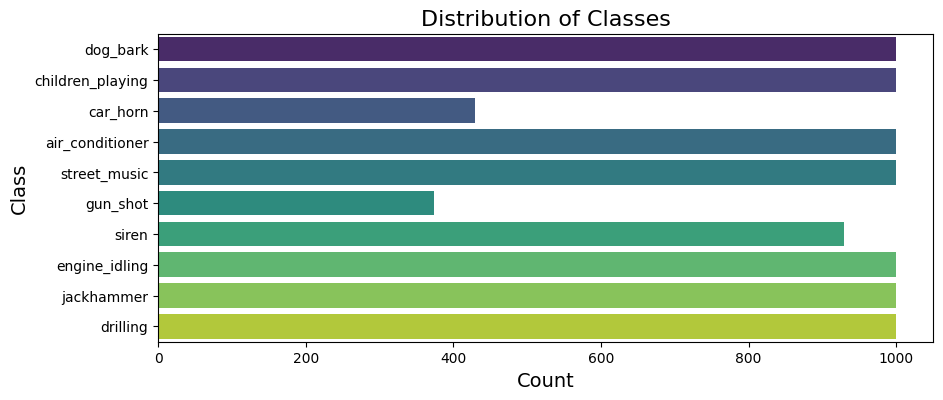

In [4]:
# Plotting count distribution of classes
plt.figure(figsize = (10, 4))
sns.countplot(y = data['class'], palette = 'viridis')
plt.title('Distribution of Classes', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

Class : siren



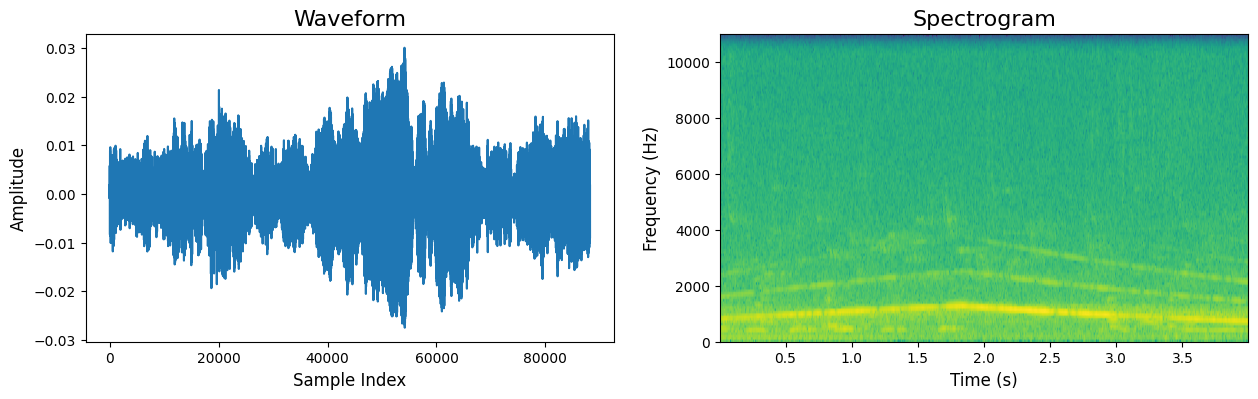

In [5]:
# Displaying a random waveform and spectrogram

# Randomly selecting a row
row = data.sample(1).iloc[0]

# Constructing file path
audioFile = os.path.join(audioPath, 'fold' + str(row['fold']), row['slice_file_name'])

# Loading audio file
waveform, sampleRate = librosa.load(audioFile)

# Displaying audio
print(f"Class : {row['class']}\n")
ipd.display(ipd.Audio(waveform, rate = sampleRate))

# Displaying waveform
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(waveform)
plt.title('Waveform', fontsize = 16)
plt.xlabel('Sample Index', fontsize = 12)
plt.ylabel('Amplitude', fontsize = 12)

# Displaying spectrogram
plt.subplot(1, 2, 2)
plt.specgram(waveform, Fs = sampleRate)
plt.title('Spectrogram', fontsize = 16)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Frequency (Hz)', fontsize = 12)

plt.show()

## Audio Feature Extraction Methods

When working with audio data, there are several methods for extracting meaningful features that can be used for various tasks such as audio classification. Here are three fundamental approaches :

a) **Using MFCCs Data**
   - This method involves extracting Mel-frequency cepstral coefficients (MFCCs) from the audio files. MFCCs capture the spectral characteristics of the sound, making them a popular choice for audio feature extraction.

b) **Using Spectrogram Images**
   - An alternative approach is to generate spectrogram images of the audio using the `melspectrogram` function in Librosa. These spectrogram images can then be treated as 2D data points, similar to how images are handled in computer vision tasks.

c) **Combining Both Features**
   - For a comprehensive representation, some approaches involve combining both MFCCs and spectrogram features. While this can potentially enhance the model's performance, it often requires more computational time for reading and extracting data.

### Chosen Approach

In this project, the chosen method for audio feature extraction is : **a) Using MFCCs Data**
   - This approach is selected for its effectiveness in capturing essential audio characteristics, providing a suitable foundation for audio classification tasks. It strikes a balance between informative features and computational efficiency.

Feel free to explore other methods based on your specific use case and computational resources.

# Preprocessing Data

## Data Augmentation
To enhance the variety in the dataset and improve the model's robustness, you can perform data augmentation on the audio files. Feel free to uncomment the code below and execute it. This code applies pre-emphasis, time stretching, and adds noise to the audio waveforms.

In [6]:
def augmentData(waveform):
    # Applying pre-emphasis
    waveform = librosa.effects.preemphasis(waveform)

    # Time stretching
    if np.random.rand() < 0.5:
        rate = np.random.uniform(0.8, 1.2)
        waveform = librosa.effects.time_stretch(waveform, rate = rate)

    # Adding noise
    waveform += 0.01 * np.random.normal(size = waveform.shape)

    return waveform

In [7]:
# Computing Mel-frequency cepstral coefficients
def mfccExtract(file):
    # Loading audio file
    waveform, sampleRate = librosa.load(file)

    # waveform = augmentData(waveform)
    features = librosa.feature.mfcc(y = waveform, sr = sampleRate, n_mfcc = 64)
    return np.mean(features, axis = 1)

In [8]:
# Storing mfcc features along with classes in dataframe
extractAll = []

# Iterating through each row
for index, row in tqdm(data.iterrows()):
    # Constructing file path
    audioFile = os.path.join(audioPath, 'fold' + str(row['fold']), row['slice_file_name'])

    # Extracting features and appending them
    features = mfccExtract(audioFile)
    extractAll.append([features, row['class']])

8732it [51:38,  2.82it/s]


In [9]:
featuresDf = pd.DataFrame(extractAll, columns = ['Features', 'Class'])
featuresDf.head()

,Features,Class
0,"[-211.93698, 62.58121, -122.813156, -60.745293...",dog_bark
1,"[-417.0052, 99.336624, -42.995583, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.57807, 43.195866, ...",children_playing
3,"[-406.47922, 91.1966, -25.043552, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658783, 50.690285,...",children_playing


In [10]:
# Converting features into numpy array
x = np.array(featuresDf['Features'].tolist())

# Encoding classes
encoder = LabelEncoder()
y = encoder.fit_transform(featuresDf['Class'])
y = to_categorical(y, num_classes = 10)

In [11]:
# Train-validation split
trainX, testX, trainY, testY = train_test_split(x, y, stratify = y, random_state = 0)

# Defining Model

In [12]:
model = Sequential([
    layers.Dense(1024, activation = 'relu', input_shape = (64,)),
    layers.BatchNormalization(),

    layers.Dense(512, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(128, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(64, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(32, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(10, activation = 'softmax')
])

# Defining optimizer, loss function, and metrics
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              66560     
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1

In [13]:
# Adding early stopping to avoid overfitting
earlyStopping = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 5e-4,
    patience = 5,
    restore_best_weights = True
)

In [14]:
# Adding a learning rate annealer
reduceLR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-5
)

In [15]:
# Training model
history = model.fit(
    trainX, trainY,
    validation_data = (testX, testY),
    epochs = 50,
    callbacks = [earlyStopping, reduceLR]
)

Epoch 1/50
205/205 [==============================] - 11s 36ms/step - loss: 1.4567 - accuracy: 0.5263 - val_loss: 1.1742 - val_accuracy: 0.6148 - lr: 0.0010
Epoch 2/50
205/205 [==============================] - 5s 24ms/step - loss: 0.9930 - accuracy: 0.6854 - val_loss: 0.8530 - val_accuracy: 0.7306 - lr: 0.0010
Epoch 3/50
205/205 [==============================] - 5s 25ms/step - loss: 0.8050 - accuracy: 0.7453 - val_loss: 0.8129 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 4/50
205/205 [==============================] - 6s 30ms/step - loss: 0.6728 - accuracy: 0.7827 - val_loss: 0.7811 - val_accuracy: 0.7586 - lr: 0.0010
Epoch 5/50
205/205 [==============================] - 5s 22ms/step - loss: 0.5816 - accuracy: 0.8100 - val_loss: 0.5328 - val_accuracy: 0.8291 - lr: 0.0010
Epoch 6/50
205/205 [==============================] - 6s 28ms/step - loss: 0.4869 - accuracy: 0.8438 - val_loss: 0.5069 - val_accuracy: 0.8465 - lr: 0.0010
Epoch 7/50
205/205 [==============================] - 5s 25ms/s

In [16]:
historyDf = pd.DataFrame(history.history)

<Axes: >

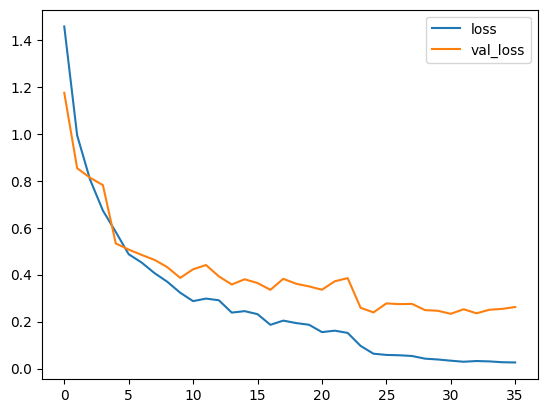

In [17]:
# Plotting training and validation loss
historyDf.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

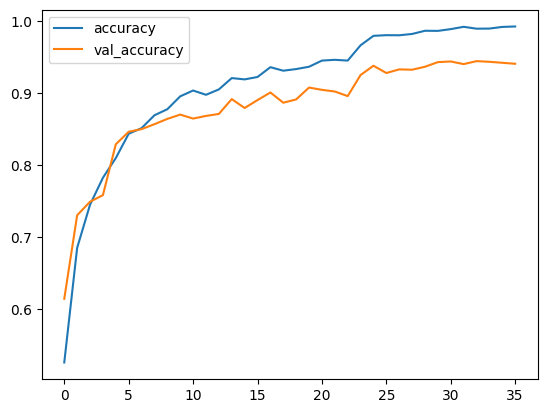

In [18]:
# Plotting training and validation accuracy
historyDf.loc[:, ['accuracy', 'val_accuracy']].plot()

In [19]:
# Evaluating model
score = model.evaluate(testX, testY)[1] * 100
print(f'Validation accuracy of model : {score:.2f}%')

69/69 [==============================] - 0s 6ms/step - loss: 0.2334 - accuracy: 0.9441
Validation accuracy of model : 94.41%


69/69 [==============================] - 1s 6ms/step


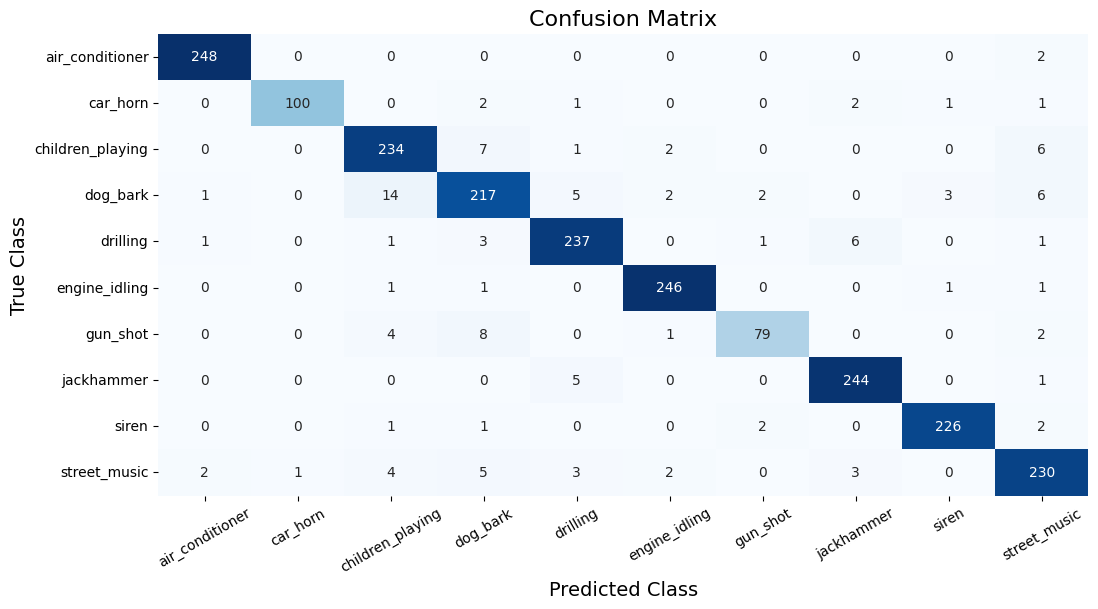

In [20]:
# Plotting confusion matrix
pred = np.argmax(model.predict(testX), axis = 1)
true = np.argmax(testY, axis = 1)

matrix = confusion_matrix(true, pred)

plt.figure(figsize = (12, 6))
sns.heatmap(matrix, annot = True, cbar = False, fmt = 'd', cmap = 'Blues', xticklabels = encoder.classes_, yticklabels = encoder.classes_)
plt.title('Confusion Matrix', fontsize = 16)
plt.xlabel('Predicted Class', fontsize = 14)
plt.xticks(rotation = 30)
plt.ylabel('True Class', fontsize = 14)
plt.show()

In [22]:
# Step 1: Load your own audio file
your_audio_file = '/content/drive/MyDrive/ML/sounds/siren.mp3'

# Step 2: Extract features from your audio file
waveform, sampleRate = librosa.load(your_audio_file)
features = mfccExtract(your_audio_file)

# Step 3: Reshape the features and make predictions
features = features.reshape(1, -1)  # Reshape features for model input
prediction = model.predict(features)
predicted_class = encoder.classes_[np.argmax(prediction)]

print("Predicted class:", predicted_class)


1/1 [==============================] - 0s 84ms/step
Predicted class: siren
